In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "train_data"

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [78]:
netG = Generator(ngpu)#.to(device)
state_dict = torch.load('best_G_epoch.pt', map_location=torch.device('cpu'))
netG.load_state_dict(state_dict)
netG.to(device)
netG.eval()
# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)

# Print the model
# print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [273]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()
img_list = []
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
fixed_noise.shape

torch.Size([64, 100, 1, 1])

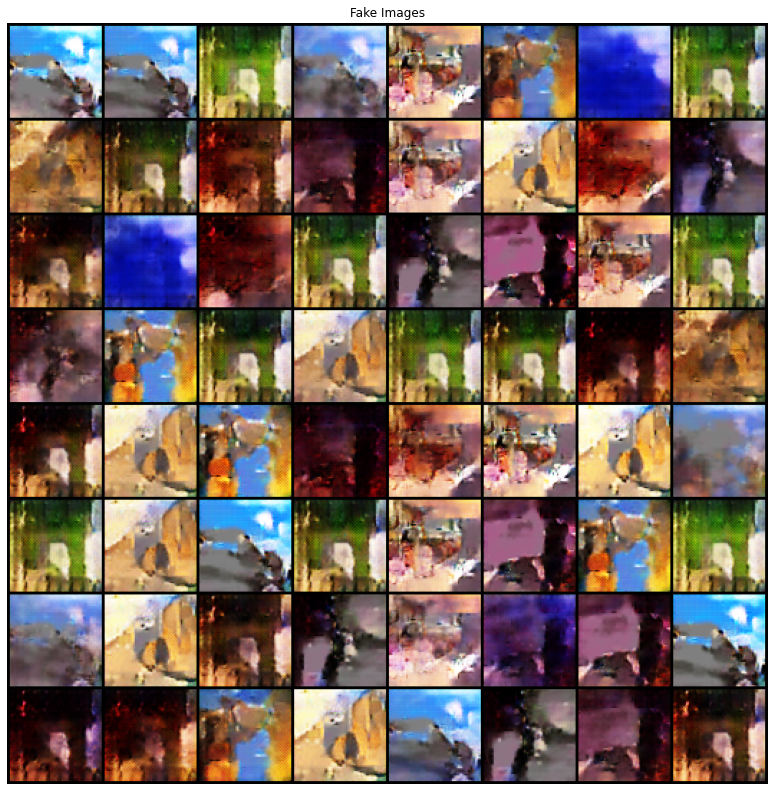

In [274]:
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# #plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

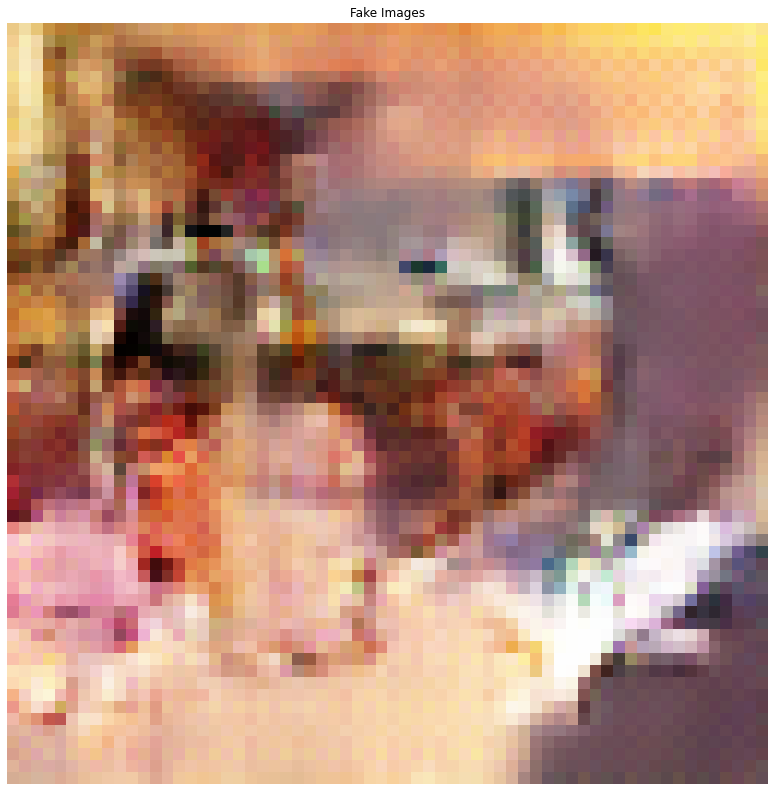

In [81]:
fixed_noise = torch.randn(1, nz,1,1)
fake = netG(fixed_noise).detach().cpu()
img_list = []
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# #plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [123]:
def convert_array_to_tensor(num, nz, offset, width, ):
    output = ((np.random.rand(num, nz,1,1)-.5)*width + offset).astype('d')
    output1 = output.astype('d')
    print(type(output1[0][0][0][0]))
    output_tensor = torch.tensor(output1)
    return output_tensor

In [124]:

fixed_noise = convert_array_to_tensor(16,100,1,1)
fixed_noise.shape

<class 'numpy.float64'>


torch.Size([64, 100, 1, 1])

In [322]:
width = 2
offset = 0
fixed_noise = ((torch.rand(64, nz, 1, 1, device=device)-0.5)*2)*width + offset

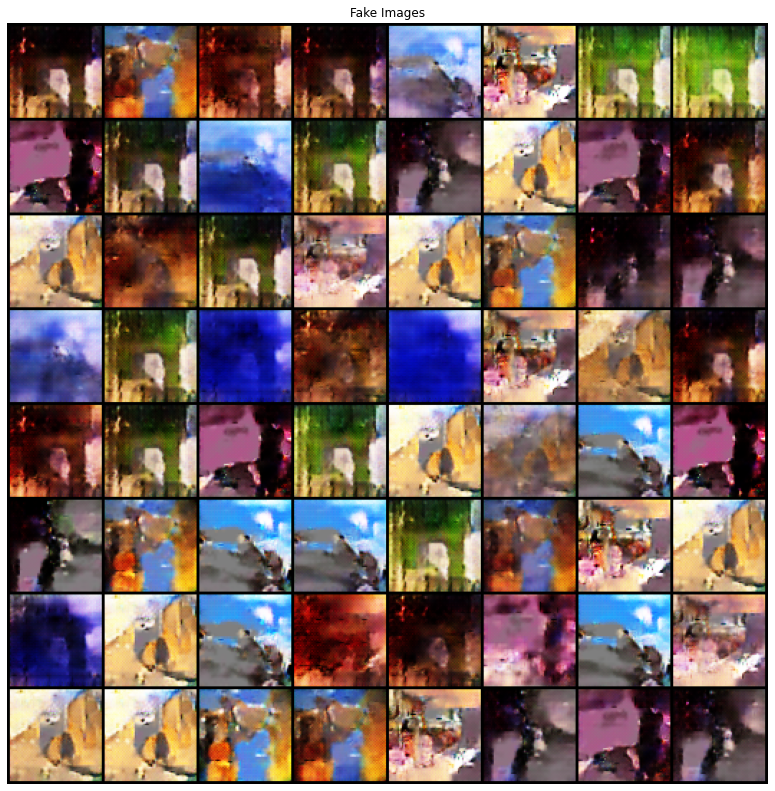

In [323]:
fake = netG(fixed_noise).detach().cpu()
img_list = []
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# #plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))